In [35]:
# Experiment 3: Sales with website correlation, Germany
import os
import tensorflow as tf
#from tensorflow.contrib.tensorboard.plugins import projector
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [36]:
df_train = pd.read_csv("bank-full.csv",sep=';')
print(np.shape(df_train))
df_train.head()


(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [37]:
#Perform Exploratory Data Analysis on each feature
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


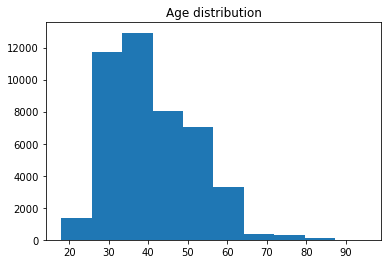

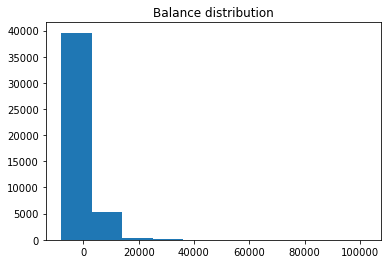

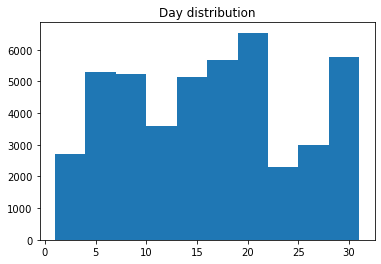

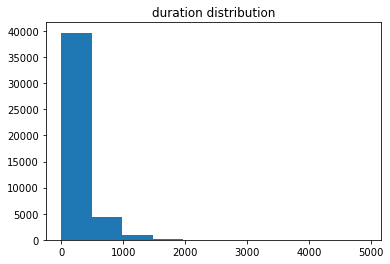

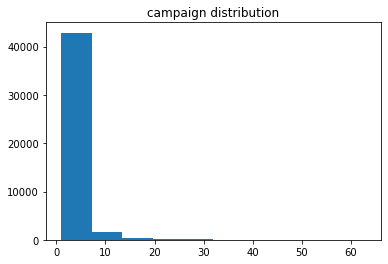

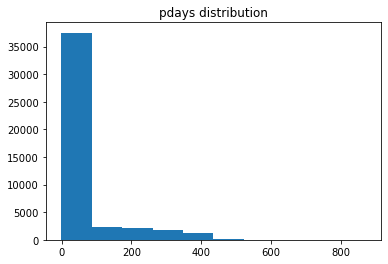

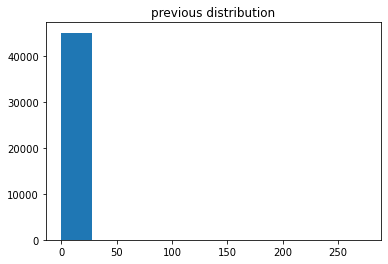

In [38]:
#X=16 features, 7 numerical, 9 categorical, Y=categorical
#Visualize distributions of each numeric feature
age=df_train["age"]
plt.hist(age)
plt.title('Age distribution')
plt.show()
balance=df_train["balance"]
plt.hist(balance)
plt.title('Balance distribution')
plt.show()
day=df_train["day"]
plt.hist(day)
plt.title('Day distribution')
plt.show()
duration=df_train["duration"]
plt.hist(duration)
plt.title('duration distribution')
plt.show()
campaign=df_train["campaign"]
plt.hist(campaign)
plt.title('campaign distribution')
plt.show()
pdays=df_train["pdays"]
plt.hist(pdays)
plt.title('pdays distribution')
plt.show()
prev=df_train["previous"]
plt.hist(prev)
plt.title('previous distribution')
plt.show()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64


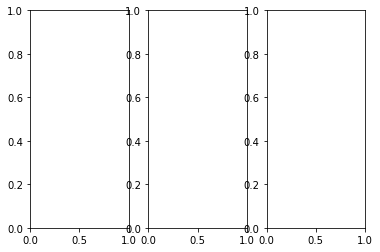

In [44]:
#Now lets look at the distribution for categorical data (saved as images)
categorical_features = ["job","marital","education"]
fig, ax = plt.subplots(1, len(categorical_features))
for i, categorical_feature in enumerate(df_train[categorical_features]):
    print(df_train[categorical_feature].value_counts())
#     plot("bar", ax=ax[i]).set_title(categorical_feature)
# fig.savefig('demo_1.png', bbox_inches='tight')

# categorical_features = ["default","housing","loan"]
# fig, ax = plt.subplots(1, len(categorical_features))
# for i, categorical_feature in enumerate(df_train[categorical_features]):
#     df_train[categorical_feature].value_counts().plot("bar", ax=ax[i]).set_title(categorical_feature)
# fig.savefig('demo_2.png', bbox_inches='tight')

# categorical_features = ["contact","month","poutcome"]
# fig, ax = plt.subplots(1, len(categorical_features))
# for i, categorical_feature in enumerate(df_train[categorical_features]):
#     df_train[categorical_feature].value_counts().plot("bar", ax=ax[i]).set_title(categorical_feature)
# fig.savefig('demo_3.png', bbox_inches='tight')

In [6]:
#All categorical features have more than one value, thus one-hot encode all categorical features
jobs=pd.get_dummies(df_train["job"],prefix='job',drop_first=True)
df_train=df_train.drop('job', 1).join(jobs)

In [7]:
df_train=df_train.drop('marital', 1).join(pd.get_dummies(df_train["marital"],prefix='marital',drop_first=True))
df_train=df_train.drop('education', 1).join(pd.get_dummies(df_train["education"],prefix='edu',drop_first=True))
df_train=df_train.drop('default', 1).join(pd.get_dummies(df_train["default"],prefix='default',drop_first=True))
df_train=df_train.drop('housing', 1).join(pd.get_dummies(df_train["housing"],prefix='housing',drop_first=True))
df_train=df_train.drop('loan', 1).join(pd.get_dummies(df_train["loan"],prefix='loan',drop_first=True))
df_train=df_train.drop('contact', 1).join(pd.get_dummies(df_train["contact"],prefix='contact',drop_first=True))
df_train=df_train.drop('month', 1).join(pd.get_dummies(df_train["month"],prefix='month',drop_first=True))
df_train=df_train.drop('poutcome', 1).join(pd.get_dummies(df_train["poutcome"],prefix='poutcome',drop_first=True))

In [8]:
df_train.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,no,0,0,...,0,0,0,1,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,no,0,0,...,0,0,0,1,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,no,0,1,...,0,0,0,1,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,no,1,0,...,0,0,0,1,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,no,0,0,...,0,0,0,1,0,0,0,0,0,1


In [9]:
Y=pd.get_dummies(df_train["y"],drop_first=True)
print(Y[0:5])
print(len(Y))
df_train=df_train.drop('y', 1)
df_train.head()

   yes
0    0
1    0
2    0
3    0
4    0
45211


,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


(45211, 1)


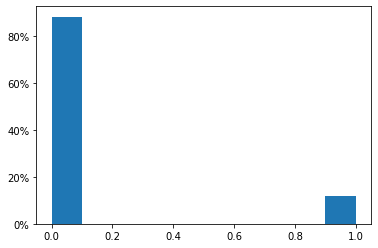

0.11698480458295547


In [10]:
Y1=np.array(Y).astype(int)
print(np.shape(Y1))
from matplotlib.ticker import PercentFormatter
plt.hist(Y1,weights=np.ones(len(Y1)) / len(Y1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()
print(np.count_nonzero(Y1)/len(Y1))
#Thus, the data is highly unbalanced, 11.7% purchased, 88.3% not purchased

In [11]:
df_train.head()
#Data Pre-processing is complete, 42 features per sample extracted

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


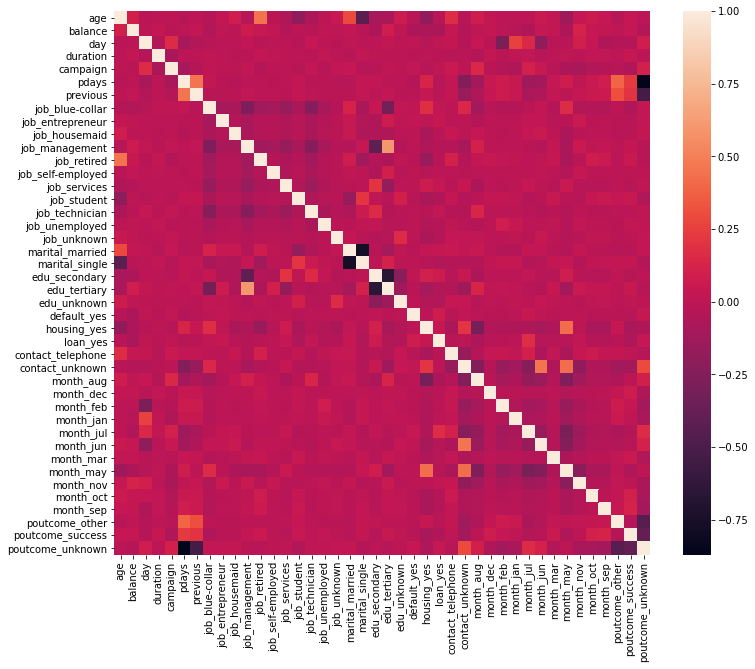

In [12]:
#Step 1: Feature correlation, Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_train.corr()
sns.heatmap(cor)
plt.show()
#Some intersting correlations pop up that need further analysis (later)
#we need to eliminate features that have very high absolute correlations

In [17]:
columns = np.full((cor.shape[0],), True, dtype=bool)
for i in range(cor.shape[0]):
    for j in range(i+1, cor.shape[0]):
        if np.abs(cor.iloc[i,j]) >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = df_train.columns[columns]
df_out = df_train[selected_columns]
print(selected_columns)
df_train.head()
#1 feature dropped

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'edu_secondary', 'edu_tertiary',
       'edu_unknown', 'default_yes', 'housing_yes', 'loan_yes',
       'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_other',
       'poutcome_success'],
      dtype='object')


,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [22]:
#Step 2: Feature Selection on p-value (statistical significance to Y value)
selected_columns = selected_columns[0:]
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.01
data_modeled, selected_columns = backwardElimination(df_out.values, Y1, SL, selected_columns)

['age' 'balance' 'day' 'duration' 'campaign' 'job_retired' 'job_student'
 'marital_single' 'edu_secondary' 'edu_tertiary' 'housing_yes' 'loan_yes'
 'contact_unknown' 'month_aug' 'month_dec' 'month_jan' 'month_jul'
 'month_jun' 'month_mar' 'month_may' 'month_nov' 'month_oct' 'month_sep'
 'poutcome_other' 'poutcome_success']


In [24]:
print(selected_columns)
print(len(selected_columns))
#Thus 25 features are relevant from 42 features
data_red = pd.DataFrame(data = data_modeled, columns = selected_columns)

['age' 'balance' 'day' 'duration' 'campaign' 'job_retired' 'job_student'
 'marital_single' 'edu_secondary' 'edu_tertiary' 'housing_yes' 'loan_yes'
 'contact_unknown' 'month_aug' 'month_dec' 'month_jan' 'month_jul'
 'month_jun' 'month_mar' 'month_may' 'month_nov' 'month_oct' 'month_sep'
 'poutcome_other' 'poutcome_success']
25


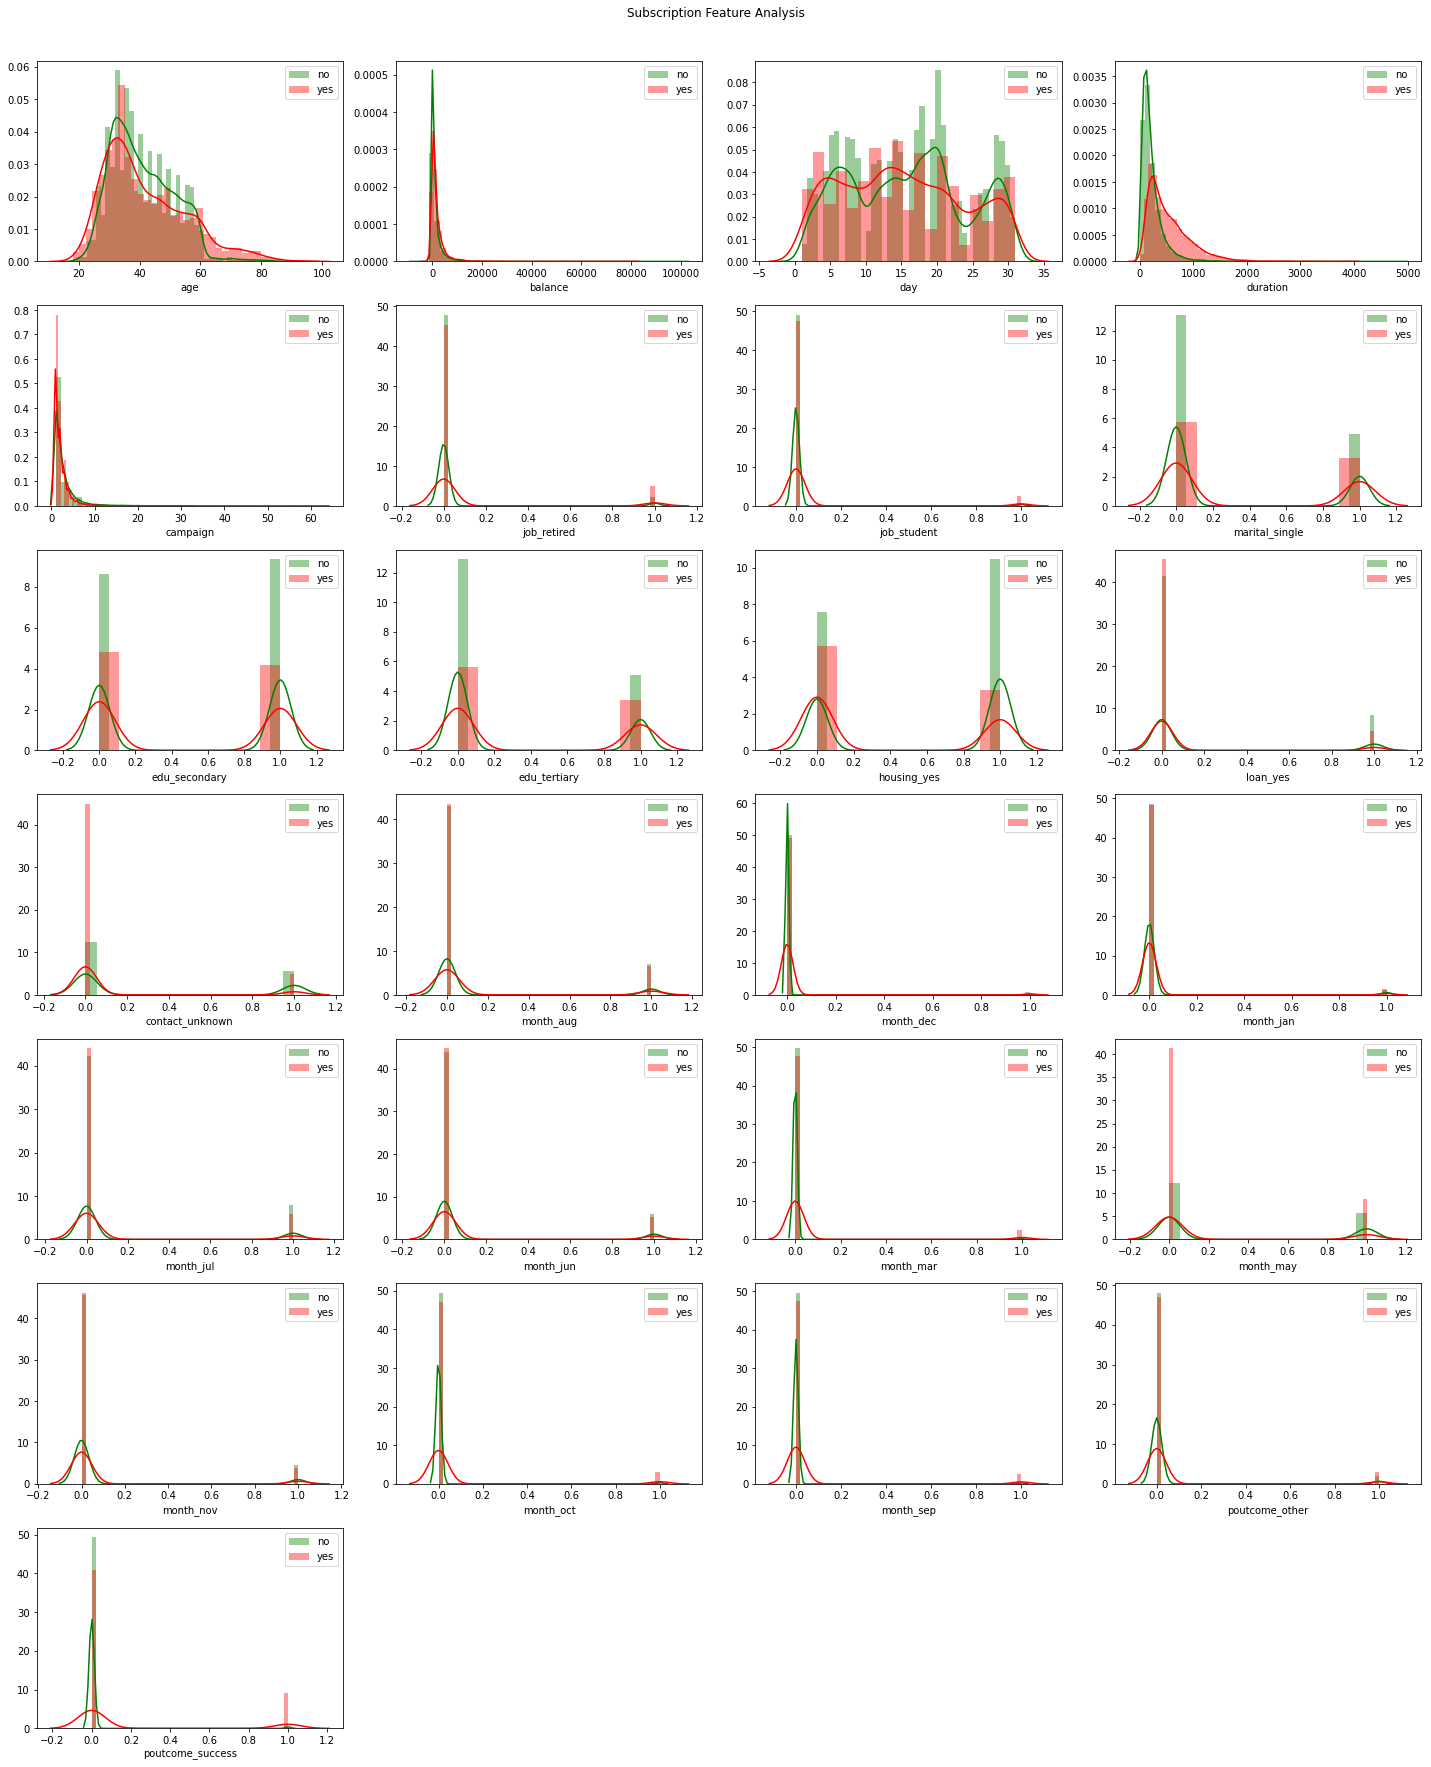

In [25]:
#Visualize the selected features
result = pd.DataFrame(Y).astype(int)


fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_red.columns:
    plt.subplot(7, 4, j+1)
    j += 1
    sns.distplot(data_red[i][result['yes']==0], color='g', label = 'no')
    sns.distplot(data_red[i][result['yes']==1], color='r', label = 'yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [26]:
#Some Selected 29 features show more correlation to label (duration, job_type, education etc.)
#Lets do LASSO feature selection to reduce feature set more
reg = LassoCV()
reg.fit(df_train, result)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(df_train, result))
coef = pd.Series(reg.coef_, index = df_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

/home/local/VCCNET/schowdhu/anaconda3/envs/DL/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Best alpha using built-in LassoCV: 5.170680
Best score using built-in LassoCV: 0.153695
Lasso picked 2 variables and eliminated the other 40 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

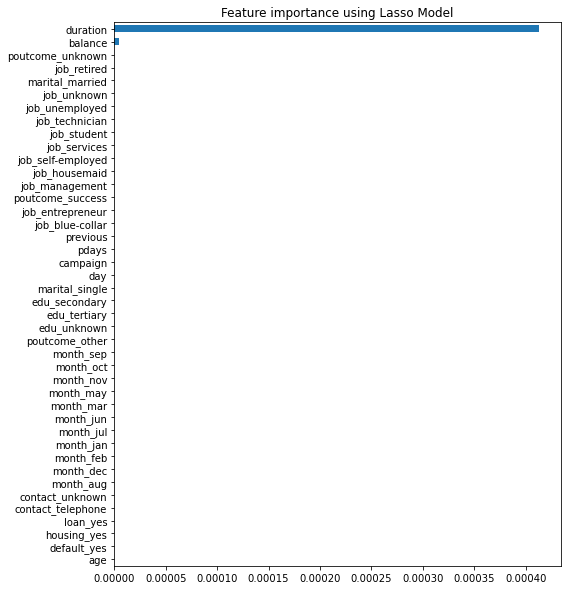

In [27]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
#pdays is the only other feature here

In [28]:
data_red.describe()
#26 overall features
#Next step, Build a classification model and predict (need for data balancing)

,age,balance,day,duration,campaign,job_retired,job_student,marital_single,edu_secondary,edu_tertiary,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,...,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,0.050076,0.020747,0.282896,0.513194,0.294198,...,0.031032,0.152507,0.118135,0.010551,0.304483,0.087810,0.016323,0.012807,0.040698,0.033421
std,10.618762,3044.765829,8.322476,257.527812,3.098021,0.218105,0.142538,0.450411,0.499831,0.455687,...,0.173407,0.359516,0.322771,0.102174,0.460193,0.283022,0.126718,0.112441,0.197592,0.179735
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
from sklearn.model_selection import cross_val_score
from numpy import mean
x_train, x_test, y_train, y_test = train_test_split(data_red.values, result.values, test_size = 0.3)

In [30]:
# The default random forest classifier, no balancing
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(x_train, y_train)
prediction=clf.predict(x_test)
cm = confusion_matrix(y_test, prediction)
sum = 0
for i in range(cm.shape[0]):
    sum += cm[i][i]
    
accuracy = sum/x_test.shape[0]
print("Accuracy=",accuracy)
scores = cross_val_score(clf, x_test, y_test, scoring='recall', cv=5)
print('Mean Recall: %.3f' % mean(scores))
print(cm)

<ipython-input-30-196902a6eb3e>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Accuracy= 0.9024624004718372


/home/local/VCCNET/schowdhu/anaconda3/envs/DL/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/local/VCCNET/schowdhu/anaconda3/envs/DL/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/local/VCCNET/schowdhu/anaconda3/envs/DL/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/local/VCCNET/schowdhu/anaconda3

Mean Recall: 0.288
[[11776   209]
 [ 1114   465]]


In [31]:
#Most data is classified as major class, hence data balancing is needed,1. Balanced Random forest, 2. SMOTE
#1.
# The default random forest classifier, balanced
clf = RandomForestClassifier(max_depth=10, random_state=0, class_weight='balanced')
clf.fit(x_train, y_train)
prediction=clf.predict(x_test)
cm = confusion_matrix(y_test, prediction)
sum = 0
for i in range(cm.shape[0]):
    sum += cm[i][i]
    
accuracy = sum/x_test.shape[0]
print("Accuracy=",accuracy)
scores = cross_val_score(clf, x_test, y_test, scoring='recall', cv=5)
print('Mean Recall: %.3f' % mean(scores))
print(cm)

<ipython-input-31-7707935a2c6e>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Accuracy= 0.8408286641108818


/home/local/VCCNET/schowdhu/anaconda3/envs/DL/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/local/VCCNET/schowdhu/anaconda3/envs/DL/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/local/VCCNET/schowdhu/anaconda3/envs/DL/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/local/VCCNET/schowdhu/anaconda3

Mean Recall: 0.774
[[10086  1899]
 [  260  1319]]


In [32]:
#We observe that accuracy is not a good output metric, (since unbalanced has higher accuracy due to true negative samples)
#Signifincat metric here is recall (with balanced data recall=0.75, no balancing=0.3)
#2. Random Forest with random undersampling
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(n_estimators=10)
clf.fit(x_train, y_train)
prediction=clf.predict(x_test)
cm = confusion_matrix(y_test, prediction)
sum = 0
for i in range(cm.shape[0]):
    sum += cm[i][i]
    
accuracy = sum/x_test.shape[0]
print("Accuracy=",accuracy)
scores = cross_val_score(clf, x_test, y_test, scoring='recall', cv=5)
print('Mean Recall: %.3f' % mean(scores))
print(cm)

ModuleNotFoundError: No module named 'imblearn'

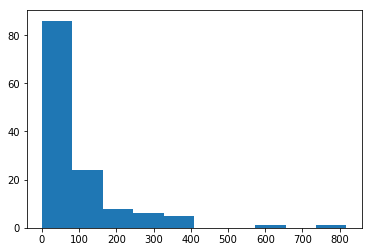

In [24]:
plt.hist(C)
plt.show()

In [25]:
# Now Implement Elocogical Inference
#  Step 1: compute joint distribution and marginals
#X=np.copy(X_red)
Z,Z_val# This is the unique config ID
#print(np.shape(X))
#####################---------------------
#Variables are X (centroid+MSRP), Y(cluster ID), Z(unique config ID, not needed), C (count)
#1. Compute J[cluster][GAxSales]
J = {}
W=[]
print(np.size(Xs,0))
for cluster in train_y:
    J[cluster] = np.zeros((np.size(Xg,0)+1,np.size(Xs,0)+1))
    idx=np.where(Y==cluster)
    #print(idx)
    Xn=X[idx,:]
    Cn=C[idx]
    Zn=Z[idx,0].flatten()
   # print(idx)
    for i in range(np.size(idx,1)): 
        
        idz=np.where(Z==Zn[i])#This is to check if same config exists in sales and GA or not
        if(np.size(idz,1)>1):#This means same config exists in both data sets
            col=idz[0][0]
            row=idz[0][1]-np.size(Xs,0)
        else:#This means single copy of config only
            if(idz[0][0]<np.size(Xs,0)):#This means single copy in sales only
                col=idz[0][0]
                row=np.size(Xg,0)#others 
            else:#This means single copy in GA
                
                col=np.size(Xs,0)
                row=idz[0][0]-np.size(Xs,0)
        #print("row,col=",row,col)
        J[cluster][row,col]=J[cluster][row,col]+Cn[i]
    W.append(np.sum(Cn))
   #print("01,2=",np.sum(J[cluster][:,0]),np.sum(J[cluster][:,1]),np.sum(J[cluster][:,2]))
    J[cluster] /= J[cluster].sum()       
#W =np.add.reduce(W,1)
W=np.array(W)
W =W/np.sum(W)#This is the weight matrix
print(W)
#print(J[4])
        

66
[0.18928816 0.11748515 0.20027354 0.12196788 0.2602607  0.11072457]


In [26]:
#Create a weight matrix to weigh the outcomes of each cluster#

[4.78950215e-02 6.15747897e-02 1.01079322e-02 5.92426469e-02
 7.58346914e-02 1.53221518e-02 7.53811890e-03 8.51083902e-02
 1.47648589e-02 2.42697538e-02 8.85511163e-04 3.00218960e-02
 5.16917527e-02 3.77796708e-02 1.04584637e-02 1.34452753e-02
 1.68262431e-02 1.19924619e-03 1.58292268e-02 1.37494145e-02
 1.14091472e-02 2.31283193e-03 9.42264862e-04 4.40851647e-02
 3.69260110e-02 7.22985974e-03 1.15920662e-02 1.17930593e-02
 9.56270848e-03 3.10651892e-02 3.59773856e-03 1.28056186e-02
 2.21137596e-02 5.14298282e-03 6.83016999e-03 1.01683960e-02
 1.70885234e-03 7.79769102e-03 1.66108860e-02 6.36389417e-03
 7.52687468e-03 1.92539961e-02 8.67060389e-03 7.84991128e-03
 6.27870494e-03 3.74244921e-03 4.28302210e-04 1.42418889e-02
 9.10567646e-03 5.10624592e-03 3.57065711e-03 1.71156048e-03
 1.57628772e-02 1.17477864e-02 1.17275331e-04 1.38351923e-04
 4.69101322e-04 1.80234293e-03 3.81244935e-03 3.87838728e-03
 2.64811477e-04 1.87987894e-03 3.93979176e-04 2.07363048e-03
 8.56604420e-05 8.566044

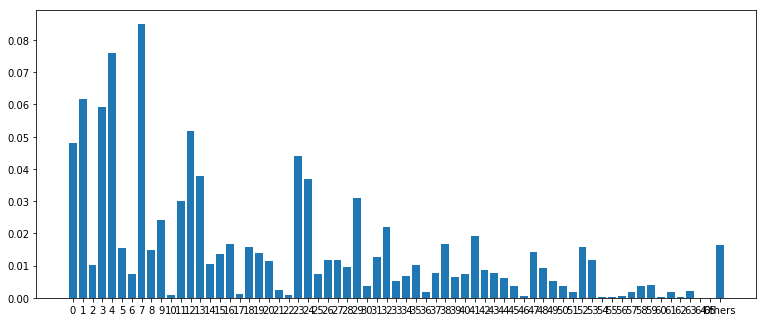

1.0000000000000002


In [27]:
#Compute sales Marginals
Sales_Marginals = {}
categories = []
for j in range(np.size(Xs,0)):
    categories.append(str(j))
categories.append('Others')

for cluster in train_y:
    Sales_Marginals[cluster] = pd.Series([J[cluster][:, i].sum()
                                        for i in np.arange(np.size(Xs,0)+1)])
    #print(Sales_Marginals[cluster])
    Sales_Marginals[cluster].index = categories
sa=[]
for c in train_y:
    sa.append(np.array(Sales_Marginals[c]))
    
sa=np.matmul(W,sa)
print(sa)
y_pos1 = np.arange(len(categories))

# Create bars
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = plt.axes([0,0.6,1,1])
ax.bar(y_pos1, sa)
 
# Create names on the x-axis
plt.xticks(y_pos1, categories)
 
# Show graphic
plt.show()
print(sum(sa))



(66,)


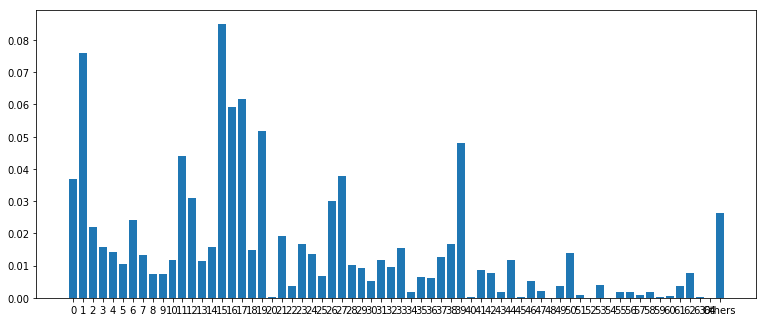

0.9999999999999999


In [47]:
#Compute configuration marginals
Config_Marginals = {}
configs = []
for j in range(np.size(Xg,0)):
    configs.append(str(j))
configs.append('Others')

for cluster in train_y:
    Config_Marginals[cluster] = pd.Series([J[cluster][i, :].sum()
                                             for i in np.arange(np.size(Xg,0)+1)])
    Config_Marginals[cluster].index = configs
print(np.shape(Config_Marginals[1]))
co=[]
for c in train_y:
    co.append(np.array(Config_Marginals[c]))
    
#co=np.add.reduce(co,0)
co=np.matmul(W,co)
y_pos = np.arange(len(configs))

# Create bars
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = plt.axes([0,0.6,1,1])
ax.bar(y_pos, co)
 
# Create names on the x-axis
plt.xticks(y_pos, configs)
 
# Show graphic
plt.show()
print(sum(co))

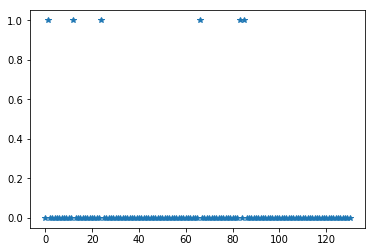

<class 'numpy.ndarray'>


In [48]:
plt.plot(X[:,72],'*')
plt.show()
print(type(C))

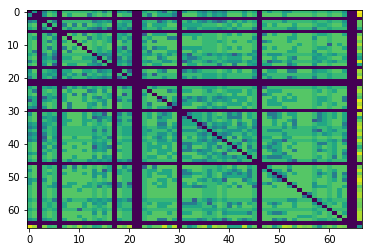

(131, 74)


In [102]:
# Cost Function, independent of cluster ID, Modify this function
from Trot import Distances as dist
import Trot.Distances as Distances
import Trot.Projections as Projections
import Trot.Tsallis as Tsallis

from Trot.Evaluation import KL
from Trot.Volvo_inference_try import CV_Local_Inference, Local_Inference
features = ['Data Position','MSRP','Fraction']
co_len, ca_len = len(configs), len(categories)
#M=np.zeros((co_len, ca_len))
M = np.dot(0,np.ones((co_len, ca_len)))
#To cater to "others"
avg_by_e_oth=np.zeros((np.size(Xg,1)+1))
avg_by_p_oth=np.zeros((np.size(Xg,1)+1))
a_p=0
a_e=0

for i in range(np.size(Xg,0)):
    idx=np.where(Z==Z[i])
    if(np.size(idx,1)>1):#not unique to one data set
        average_by_e=np.concatenate(X[idx,:],axis=0).mean(0)
        cost=np.mean([C[idx[0][0]],C[idx[0][1]]])/np.sum(Count_train)
        average_by_e=np.append(average_by_e,cost)
        
    else:#move to others category
        #print(idx)
        average_by_e=Xg[i,:]
        cost=Count_GA[i]/np.sum(Count_train)
        i=np.copy(np.size(Xg,0))
        avg_by_e_oth=avg_by_e_oth+np.append(average_by_e,cost)
        a_e=a_e+1
        average_by_e=avg_by_e_oth/a_e
    
    #print("e=",np.shape(average_by_e),idx)
    
    #average_by_e = np.mean(X[idx,:],axis=0)
    #print("e=",np.shape(average_by_e))
        
    for j in range(np.size(Xs,0)):
        jdx=np.where(Z==Z[j])
        if(np.size(jdx,1)>1):#not unique to one data set
            average_by_p=np.concatenate(X[jdx,:],axis=0).mean(0)
            costs=np.mean([C[jdx[0][0]],C[jdx[0][1]]])/np.sum(Count_train)
            average_by_p=np.append(average_by_p,costs)
        else:#move to others category
            #print(jdx)
            average_by_p=Xs[j,:]
            costs=Count_train[j]/np.sum(Count_train)
            j=np.copy(np.size(Xs,0))
            #print(np.shape(avg_by_p_oth))
            #print(np.shape(np.append(average_by_p,costs)))
            avg_by_p_oth=avg_by_p_oth+np.append(average_by_p,costs)
            a_p=a_p+1
            average_by_p=avg_by_p_oth/a_p
        
       
       
            #average_by_e = np.mean(X[idx,:],axis=0)
        #print("p=",np.shape(average_by_p),jdx)
        #print(np.linalg.norm(average_by_e-average_by_p))
       # print(cost,costs)
        #M[i, j] = np.array(dist.dist_2(average_by_e,average_by_p))
        M[i, j] = np.array(np.linalg.norm(average_by_e-average_by_p))
#print(np.shape(M))
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(M,interpolation='nearest',aspect='auto')
plt.show()
print(np.shape(X))

In [103]:
from Tsallis import TROT
from Unregularized_OT import Unregularized_OT
from Evaluation import KL

def CV_Local_Inference(X, M, J, Config_Marginals, Sales_Marginals, CV_clusters,q,l, filename = None):

    best_kl = np.Inf
    q_best = q[0]
    l_best = l[0]
    variance_best = 0
    print("Begin grid search")
    if filename is not None:
        file = open('{0}.txt'.format(filename), "w")
        file.write('q, l, kl\n')
#Finding best paremeters by grid search#######################################
    for j in range(len(q)):
        for i in range(len(l)):

            J_inferred = {}
            for cluster in CV_clusters:
                
                r = Config_Marginals[cluster]
                c = Sales_Marginals[cluster]
                #print(np.shape(r),np.shape(c))
                Infered_Distrib = TROT(q[j],M,r,c,l[i],0.001)
                #print(Inferred_Distrib)###### Error happens here
                J_inferred[cluster] = Infered_Distrib / Infered_Distrib.sum()

            kl, std = KL(J, J_inferred, CV_clusters)
            print('q: %.2f, lambda: %.4f, KL: %.4g, STD: %.4g' % (q[j], l[i], kl, std))
            if filename is not None:
                file.write('%.2f, %.4f, %.4g\n' % (q[j], l[i], kl))

            if kl < best_kl:
                q_best = q[j]
                l_best = l[i]
                variance_best = std
                best_kl = kl


    print('Best score: %.4g, Best q: %.2f, Best lambda: %.4f\t Standard Variance: %.4g\n' % (best_kl, q_best, l_best, variance_best))
#
    if filename is not None:
        file.close()
#
    return best_kl, q_best, l_best

In [104]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 15 11:38:13 2016

@author: boris
"""


import numpy as np
import math
from copy import deepcopy
from Projections import check, Sinkhorn
from Distances import inner_Frobenius


#Tsallis generalization of the exponential
def q_exp (q,u):
    return np.power(1+(1-q)*u,1/(1-q))

#Tsallis generalization of the logarithm
def q_log (q,u):
    return (np.power(u,1-q) - 1)/(1-q)

#Objective function of the TROT minimization problem
def q_obj(q,P,M,l):
    P_q = np.power(P,q)
    return inner_Frobenius(P,M) - np.sum(P_q - P)/((1-q)*l)

#Gradient of the objective function in q-space
def q_grad(q,P,M,l):
    return M + (q*np.power(P,q-1) - 1)/(l*(1-q))

def sign(x):
    if (x>0):
        return 1 
    else:
        return -1    
    
#A wrapper for the three TROT-solving algorithms, depending on the value of q
#q must be positive
def TROT(q,M,r,c,l,precision):
    
    assert (q >= 0),"Invalid parameter q: q must be strictly positive"

    if np.isclose(q,1):
        #Add multipliers to rescale A and avoid dividing by zero
        A = deepcopy(l*M)
        A = A-np.amin(A,axis = 0)
        A = (A.T-np.amin(A,axis = 1)).T
        
        return Sinkhorn(np.exp(-A),r,c,precision)
   
    elif q<1:
        return second_order_sinkhorn(q,M,r,c,l,precision)[0]

    else:
        return KL_proj_descent(q,M,r,c,l,precision, 50, rate = 1, rate_type = "square_summable")[0]


#A TROT optimizer using first order approximations (less efficient than second order)
def first_order_sinkhorn(q,M,r,c,l,precision):

    q1  = q_exp(q,-1)

    P = q1/q_exp(q,l*M)
    A = deepcopy(l*M)

    p = P.sum(axis = 1)
    s = P.sum(axis = 0)

    count = 0
    alpha = np.zeros(M.shape[0])
    beta = np.zeros(M.shape[1])

    while not (check(p,s,r,c,precision)) and count <= 1000:

        alpha = np.divide(p-r,np.sum(np.divide(P,(1+(1-q)*A)),axis = 1))
        A = (A.transpose() + alpha).transpose()

        P = q1/q_exp(q,A)
        s = P.sum(axis = 0)

        beta = np.divide(s-c,np.sum(np.divide(P,(1+(1-q)*A)),axis = 0))
        A += beta


        P = q1/q_exp(q,A)
        p = P.sum(axis = 1)
        s = P.sum(axis = 0)



        count +=1

    return P, count, q_obj(q,P,M,l)


#The TROT optimizing algorithm from the paper -- to use when q is in (0,1)
def second_order_sinkhorn(q,M,r,c,l,precision):

    n = M.shape[0]
    m = M.shape[1]
    q1  = q_exp(q,-1)

    A = deepcopy(l*M)

    #Add multipliers to make sure that A is not too large 
    #We subtract the minimum on columns and then on rows 
    #This does not change the solution of TROT 
    A = A-np.amin(A,axis = 0)
    A = (A.T-np.amin(A,axis = 1)).T
    
    P = q1/q_exp(q,A)

    p = P.sum(axis = 1)
    s = P.sum(axis = 0)

    count = 0
    alpha = np.zeros(M.shape[0])
    beta = np.zeros(M.shape[1])

    while not (check(p,s,r,c,precision)) and count <= 1000:


        A_q2 = np.divide(P,(1+(1-q)*A))
        a = (1-q/2)*(np.sum(np.divide(A_q2,(1+(1-q)*A)),axis = 1))
        b = - np.sum(A_q2,axis = 1)
        d = np.array(p-r)
        delta = np.array(np.multiply(b,b) - 4*np.multiply(a,d))
#         print("delta=",delta)
#         print("d=",type(d))
        # print("a=",type(a))

        
        for i in range(n):
            
            if (delta[i] >=0 and d[i]<0 and a[i]>0):
                alpha[i] = - (b[i] + math.sqrt(delta[i]))/(2*a[i])
            elif (b[i] != 0):
                alpha[i] = 2*d[i]/(-b[i])
            else: alpha[i] = 0
            
            #Check that the multiplier is not too large
            if abs(alpha[i]) > 1/((2-2*q)*max(1+(1-q)*A[i,:])):
                alpha[i] = sign(d[i])*1/((2-2*q)*max(1+(1-q)*A[i,:]))

        A = (A.transpose() + alpha).transpose()


        P = q1/q_exp(q,A)
        
        s = P.sum(axis = 0)

        A_q2 = np.divide(P,(1+(1-q)*A))
        a = (1-q/2)*(np.sum(np.divide(A_q2,(1+(1-q)*A)),axis = 0))
        b = - np.sum(A_q2,axis = 0)
        d = s - c
        delta = np.multiply(b,b) - 4*np.multiply(a,d)


        for i in range(m):
            if (delta[i] >=0 and d[i]<0 and a[i]>0):
                beta[i] = - (b[i] + math.sqrt(delta[i]))/(2*a[i])
            elif (b[i] != 0):
                beta[i] = 2*d[i]/(-b[i])
            else: beta[i] = 0
            
            #Check that the multiplier is not too large
            if abs(beta[i]) > 1/((2-2*q)*max(1+(1-q)*A[:,i])):
                beta[i] = sign(d[i])*1/((2-2*q)*max(1+(1-q)*A[:,i]))
        A += beta


        P = q1/q_exp(q,A)
        
        p = P.sum(axis = 1)
        s = P.sum(axis = 0)

        count +=1
    
    #print(P.sum())

    return P, count, q_obj(q,P,M,l)
    
    
#Kullback-Leibler projected gradient method, to use when q > 1
def KL_proj_descent(q,M,r,c,l ,precision,T , rate = None, rate_type = None):
    
    if (q<=1): print("Warning: Projected gradient methods only work when q>1")    
    
    omega = math.sqrt(2*np.log(M.shape[0]))
    ind_map = np.asarray(np.matrix(r).transpose().dot(np.matrix(c)))   
    
    P = deepcopy(ind_map)

    new_score = q_obj(q,P,M,l)
    scores = []
    scores.append(new_score)
    
    best_score = new_score
    best_P= P
    
    count = 1    
    
    while count<=T: 
        
        G = q_grad(q,P,M,l)        
        
        
        if rate is None:
            tmp = np.exp(G*(-omega/(math.sqrt(T)*np.linalg.norm(G,np.inf)))) #Absolute horizon
            #tmp = np.exp(G*(-omega/(math.sqrt(count)*np.linalg.norm(G,np.inf)))) #Rolling horizon
        elif rate_type is "constant":
            tmp = np.exp(G*(-rate))
        elif rate_type is "constant_length":
            tmp = np.exp(G*(-rate*np.linalg.norm(G,np.inf)))
        elif rate_type is "diminishing":
            tmp = np.exp(G*(-rate/math.sqrt(count)))
        elif rate_type is "square_summable":
            tmp = np.exp(G*(-rate/count))
        
            
        P = np.multiply(P,tmp)
        P = Sinkhorn(P,r,c,precision)
        
        #Update score list
        new_score = q_obj(q,P,M,l)
        scores.append(new_score)  
        
        #Keep track of the best solution so far
        if (new_score < best_score):
            best_score = new_score
            best_P = P
        

        count+=1

    return best_P, scores

In [105]:
#Start the Inference
q = np.arange(0.05, 3.0, 0.1)
l = [0.001, 0.01, 1., 10.] 
CV_clusters=[0,4]

best_score, best_q, best_l = CV_Local_Inference(X, M, J, Config_Marginals, Sales_Marginals,CV_clusters,q,l)

Begin grid search


/home/local/VCCNET/schowdhu/ML_test/Joint_distrib/Projections.py:66: RuntimeWarning: divide by zero encountered in true_divide
  if (np.linalg.norm(np.divide(p,r)-1,np.inf)>prec) or (np.linalg.norm(np.divide(q,c)-1,np.inf)>prec):


q: 0.05, lambda: 0.0010, KL: 32.15, STD: 0.05757
q: 0.05, lambda: 0.0100, KL: 32.15, STD: 0.05764
q: 0.05, lambda: 1.0000, KL: 32.16, STD: 0.06528
q: 0.05, lambda: 10.0000, KL: 32.22, STD: 0.1142
q: 0.15, lambda: 0.0010, KL: 32.65, STD: 0.005977
q: 0.15, lambda: 0.0100, KL: 32.65, STD: 0.005971
q: 0.15, lambda: 1.0000, KL: 32.65, STD: 0.005299
q: 0.15, lambda: 10.0000, KL: 32.66, STD: 0.0003
q: 0.25, lambda: 0.0010, KL: 32.54, STD: 0.005267
q: 0.25, lambda: 0.0100, KL: 32.54, STD: 0.005277
q: 0.25, lambda: 1.0000, KL: 32.54, STD: 0.006481
q: 0.25, lambda: 10.0000, KL: 32.56, STD: 0.01623
q: 0.35, lambda: 0.0010, KL: 32.07, STD: 0.07146
q: 0.35, lambda: 0.0100, KL: 32.07, STD: 0.07152
q: 0.35, lambda: 1.0000, KL: 32.08, STD: 0.07749
q: 0.35, lambda: 10.0000, KL: 32.13, STD: 0.1216
q: 0.45, lambda: 0.0010, KL: 31.37, STD: 0.1528
q: 0.45, lambda: 0.0100, KL: 31.37, STD: 0.153
q: 0.45, lambda: 1.0000, KL: 31.37, STD: 0.1758
q: 0.45, lambda: 10.0000, KL: 31.49, STD: 0.3771
q: 0.55, lambda: 

/home/local/VCCNET/schowdhu/ML_test/Joint_distrib/Projections.py:66: RuntimeWarning: invalid value encountered in true_divide
  if (np.linalg.norm(np.divide(p,r)-1,np.inf)>prec) or (np.linalg.norm(np.divide(q,c)-1,np.inf)>prec):
/home/local/VCCNET/schowdhu/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/home/local/VCCNET/schowdhu/ML_test/Joint_distrib/Evaluation.py:56: RuntimeWarning: divide by zero encountered in log
  np.log(J_inferred[c][i, j] / np.maximum(J_true[c][i, j], EPS))
/home/local/VCCNET/schowdhu/ML_test/Joint_distrib/Evaluation.py:56: RuntimeWarning: invalid value encountered in double_scalars
  np.log(J_inferred[c][i, j] / np.maximum(J_true[c][i, j], EPS))


q: 1.05, lambda: 0.0100, KL: nan, STD: nan
q: 1.05, lambda: 1.0000, KL: nan, STD: nan
q: 1.05, lambda: 10.0000, KL: nan, STD: nan
q: 1.15, lambda: 0.0010, KL: nan, STD: nan
q: 1.15, lambda: 0.0100, KL: nan, STD: nan
q: 1.15, lambda: 1.0000, KL: nan, STD: nan
q: 1.15, lambda: 10.0000, KL: nan, STD: nan
q: 1.25, lambda: 0.0010, KL: nan, STD: nan
q: 1.25, lambda: 0.0100, KL: nan, STD: nan
q: 1.25, lambda: 1.0000, KL: nan, STD: nan
q: 1.25, lambda: 10.0000, KL: nan, STD: nan
q: 1.35, lambda: 0.0010, KL: nan, STD: nan
q: 1.35, lambda: 0.0100, KL: nan, STD: nan
q: 1.35, lambda: 1.0000, KL: nan, STD: nan
q: 1.35, lambda: 10.0000, KL: nan, STD: nan
q: 1.45, lambda: 0.0010, KL: nan, STD: nan
q: 1.45, lambda: 0.0100, KL: nan, STD: nan
q: 1.45, lambda: 1.0000, KL: nan, STD: nan
q: 1.45, lambda: 10.0000, KL: nan, STD: nan
q: 1.55, lambda: 0.0010, KL: nan, STD: nan
q: 1.55, lambda: 0.0100, KL: nan, STD: nan
q: 1.55, lambda: 1.0000, KL: nan, STD: nan
q: 1.55, lambda: 10.0000, KL: nan, STD: nan
q: 1.

In [106]:
def Local_Inference(X, M, J, Config_Marginals, Sales_Marginals, clusters,q,l):

    J_inferred = {}
    for cluster in clusters:

        r = Config_Marginals[cluster]
        c = Sales_Marginals[cluster]
        
        Infered_Distrib = TROT(q,M,r,c,l,0.001)

        J_inferred[cluster] = Infered_Distrib / Infered_Distrib.sum()

    return J_inferred

In [107]:
J_inferred = Local_Inference(X, M, J, Config_Marginals, Sales_Marginals, train_y, best_q, best_l)
kl, std = KL(J, J_inferred, train_y, save_to_file=False, compute_abs_err=True)

/home/local/VCCNET/schowdhu/ML_test/Joint_distrib/Projections.py:66: RuntimeWarning: divide by zero encountered in true_divide
  if (np.linalg.norm(np.divide(p,r)-1,np.inf)>prec) or (np.linalg.norm(np.divide(q,c)-1,np.inf)>prec):


Absolute error 0.00037892351932922755  +  4.894705394818011e-05


In [108]:
print(np.shape(J_inferred[0]))

(66, 67)


(66, 67)


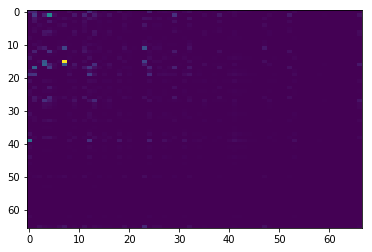

In [109]:
#Now print the result
j_true,j=[],[]
for c in train_y:
    j_true.append(np.array(J[c]))
    j.append(np.array(J_inferred[c]))
W1=np.expand_dims(W,axis=0)
j=np.squeeze(np.tensordot(W1,j,(1,0)))
j_true=np.squeeze(np.tensordot(W1,j_true,(1,0)))
print(np.shape(j_true))
imgplot_pred = plt.imshow(j,interpolation='nearest', aspect='auto')
plt.show()

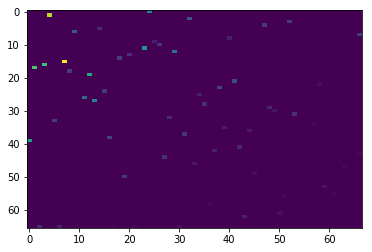

In [110]:
imgplot_act= plt.imshow(j_true,interpolation='nearest', aspect='auto')
plt.show()

In [111]:
def mse(x, y):
    return np.linalg.norm(x - y)
print(mse(j,j_true))

0.1567184363388286


(67, 66) (67, 66) (67, 66)


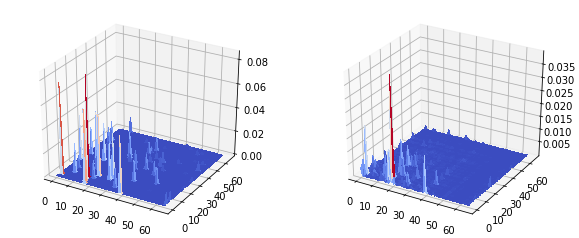

In [112]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
x = np.arange(0, np.size(j,0),1)
y = np.arange(0, np.size(j,1),1)
xv, yv = np.meshgrid(x, y)
z=np.transpose(j_true)
print(np.shape(xv),np.shape(yv),np.shape(z))
h = ax.plot_surface(xv,yv,z,rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(xv,yv,np.transpose(j),rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

In [88]:
#Export j, j_true